In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pickle
import scipy.stats
from tqdm import tqdm_notebook
from sklearn.decomposition import IncrementalPCA 
from helpers.data_generator import process_data

Using TensorFlow backend.


In [2]:
%matplotlib inline
font={'family': 'Times New Roman',
      'size': 10}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

In [3]:
data_path = '/scratch/gpfs/jabbate/mixed_data/final_data_batch_68.pkl'
with open(data_path,'rb') as f:
    rawdata = pickle.load(f, encoding='latin1')

In [4]:
keys = list(rawdata[list(rawdata.keys())[0]].keys())
keys.sort()
keys

['C_coil_139',
 'C_coil_19',
 'C_coil_199',
 'C_coil_259',
 'C_coil_319',
 'C_coil_79',
 'C_coil_method',
 'C_coil_nonstandard_139',
 'C_coil_nonstandard_199',
 'C_coil_nonstandard_79',
 'F_coil_1a',
 'F_coil_1b',
 'F_coil_2a',
 'F_coil_2b',
 'F_coil_3a',
 'F_coil_3b',
 'F_coil_4a',
 'F_coil_4b',
 'F_coil_5a',
 'F_coil_5b',
 'F_coil_6a',
 'F_coil_6b',
 'F_coil_7a',
 'F_coil_7b',
 'F_coil_8a',
 'F_coil_8b',
 'F_coil_9a',
 'F_coil_9b',
 'I_coil_150L',
 'I_coil_150U',
 'I_coil_210L',
 'I_coil_210U',
 'I_coil_270L',
 'I_coil_270U',
 'I_coil_30L',
 'I_coil_30U',
 'I_coil_330L',
 'I_coil_330U',
 'I_coil_90L',
 'I_coil_90U',
 'I_coil_method',
 'I_coil_nonstandard_150',
 'I_coil_nonstandard_30',
 'I_coil_nonstandard_90',
 'a_EFIT01',
 'a_EFIT02',
 'a_EFITRT1',
 'a_EFITRT2',
 'beam_feedback_power_target_quantity',
 'beam_feedback_power_target_value',
 'beam_feedback_switch',
 'beam_feedback_torque_target_quantity',
 'beam_feedback_torque_target_value',
 'beam_target_power',
 'beam_target_torque

In [5]:
actuator_names = ['pinj','tinj','curr','gasA']
profile_names = ['temp','dens','press_EFIT01','rotation','ffprime_EFIT01','q_EFIT01']
sig_names = actuator_names + profile_names
normalization_method = 'RobustScaler'
lookbacks = {}
for sig in actuator_names:
    lookbacks[sig] = 6
for sig in profile_names:
    lookbacks[sig] = 1
lookahead = 3
sample_step=1
window_overlap=0
window_length=1
uniform_normalization=True
data, valdata, normalization_params = process_data(rawdata, sig_names, normalization_method, window_length,
                                                    window_overlap, lookbacks, lookahead, sample_step,
                                                    uniform_normalization, train_frac=0.8, val_frac=0.2,
                                                    nshots=12000,verbose=1, flattop_only=True)

Gathering:   0%|          | 0/48 [00:00<?, ?it/s]

Signals: curr, dens, ffprime_EFIT01, gasA, pinj, press_EFIT01, q_EFIT01, rotation, temp, tinj
Number of useable shots:  48
Number of shots used:  48
Total number of timesteps:  13261


/home/wconlin/plasma-profile-predictor/helpers/data_generator.py:308: RuntimeWarning: Mean of empty slice
  return np.nanmean(array[start:start+window_length], axis=0)
Stacking:  47%|####7     | 9/19 [00:00<00:00, 82.26it/s]

Shots with Complete NaN: 


Removing ECH:   4%|4         | 141/3461 [00:00<00:02, 1409.91it/s]

9244 samples total


Removing weird gas:  11%|#1        | 263/2370 [00:00<00:00, 2613.93it/s]

Removed 3872 samples
5372 samples remaining


Splitting: 100%|##########| 19/19 [00:00<00:00, 2730.39it/s]

Removed 2838 samples
2534 samples remaining
2534 samples remaining after pruning
Total number of samples:  2534
Number of training samples:  2027
Number of validation samples:  507


In [55]:
# split into I/O pairs
X = {sig: data[sig][:,0,:] for sig in profile_names}
Y = {sig: data[sig][:,-1,:] for sig in profile_names}
U = {sig: data[sig] for sig in actuator_names}

In [7]:
# take SVD of inputs
params = {}
for sig in tqdm_notebook(X.keys(), position=0):
    U1,S,V = np.linalg.svd(X[sig].T, full_matrices=False)
    params[sig + '_U'] = U1
    params[sig + '_S'] = S
    params[sig + '_V'] = V

In [8]:
# extract PCA modes
kernels= {}
pca_modes = {}
num_pca_modes = 5
for sig in profile_names:
    pca_modes[sig] = params[sig + '_U'][:,0:num_pca_modes]
    kernels[sig] = np.matmul(pca_modes[sig],pca_modes[sig].T)

In [50]:
# form input/output matrices of PCA modes
Xpca = np.concatenate([np.matmul(np.diag(params[sig + '_S']),params[sig + '_V'])[0:num_pca_modes,:] for sig in profile_names],axis=0)
Ypca = np.concatenate([np.matmul(Y[sig],pca_modes[sig]).T for sig in profile_names],axis=0)
Upca = np.concatenate([U[sig].T for sig in actuator_names],axis=0)

In [51]:
# pinvert input matrix
XU = np.concatenate([Xpca,Upca],axis=0)
XUinv = np.linalg.pinv(XU)

In [52]:
# get A,B matrices
AB = np.matmul(Ypca,XUinv)
A = AB[:,0:Xpca.shape[0]]
B = AB[:,Xpca.shape[0]:]

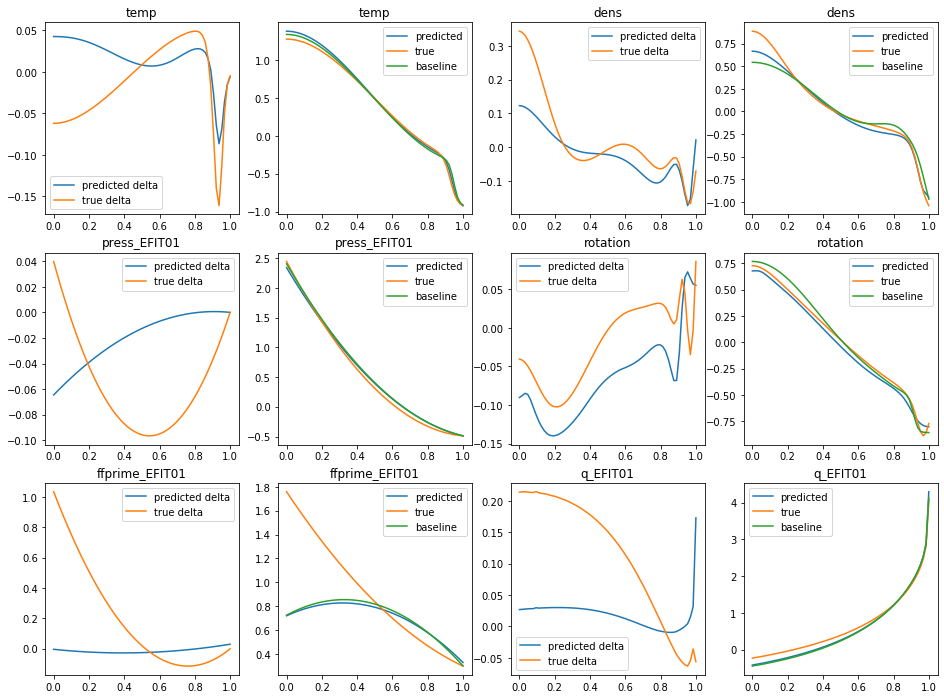

In [66]:
# test: get a set of inputs, predict output, and project back onto PCA
idx = 1
baseline = {sig: X[sig][idx,:] for sig in profile_names}
xinput = np.concatenate([np.matmul(X[sig][idx,:],pca_modes[sig]) for sig in profile_names])
uinput = np.concatenate([U[sig][idx,:] for sig in actuator_names])
youtput = np.matmul(A,xinput) + np.matmul(B,uinput)
prediction = {sig: np.matmul(youtput[i*num_pca_modes:(i+1)*num_pca_modes],pca_modes[sig].T) for i, sig in enumerate(profile_names)}
true = {sig: Y[sig][idx,:] for sig in profile_names}
#plot
psi = np.linspace(0,1,65)
figsize = (4*4,3*4)
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=figsize)
for i, sig in tqdm_notebook(enumerate(profile_names)):
        ax[np.unravel_index(2*i,(3,4))].plot(psi,prediction[sig]-baseline[sig],psi,true[sig]-baseline[sig])
        ax[np.unravel_index(2*i,(3,4))].title.set_text(sig)
        ax[np.unravel_index(2*i,(3,4))].legend(['predicted delta','true delta'])
        ax[np.unravel_index(2*i+1,(3,4))].plot(psi,prediction[sig],psi,true[sig],psi, baseline[sig])
        ax[np.unravel_index(2*i+1,(3,4))].title.set_text(sig)
        ax[np.unravel_index(2*i+1,(3,4))].legend(['predicted','true','baseline'])

In [43]:
xinput

array([-2.27883095e+00,  3.60542029e+00, -4.01253682e-01, -7.23439130e-02,
       -5.47005990e-03,  5.11950649e+00, -2.81573113e+00,  2.47514930e-03,
       -2.12316043e-01,  1.32908849e-01, -2.25344953e-01, -2.69286155e+00,
        2.19809834e-02,  2.55035191e-08,  1.33064561e-09, -1.97889302e+00,
       -2.76209821e+00, -4.38065963e-01,  1.48699167e-01,  2.73254637e-01,
        6.23201407e+00,  7.69449295e-02, -2.26955555e-01,  5.48006309e-08,
        3.98566245e-08,  1.01333462e+01, -1.33017098e-01, -5.78345522e-01,
       -2.01157141e-01,  1.03523647e-01])

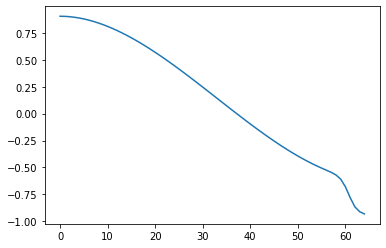

In [46]:
plt.plot(data['temp'][0,:].T)

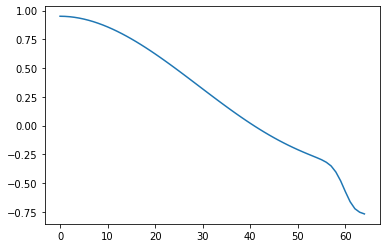

In [47]:
plt.plot(np.matmul(data['temp'][0,:],kernels['temp']))